In [1]:
# import necessary libraries 
import pyarrow
import dask.dataframe as dd
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import seaborn as sns
import os
from tensorflow import keras
from sklearn.metrics import (accuracy_score, precision_score, recall_score, confusion_matrix, precision_recall_curve, ConfusionMatrixDisplay, classification_report, auc, roc_curve, precision_recall_fscore_support, f1_score)
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses, regularizers, models
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from collections import Counter
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import RFECV
from sklearn.metrics import roc_auc_score, roc_curve


In [2]:
tf.keras.utils.set_random_seed(42)

# Paths

In [3]:
processed_dir = os.path.join( "..", "data", "processed")
final_dataset_path = os.path.join(processed_dir, 'FEData_For_Modelling.parquet')
minority_users_autoencoder_csv = os.path.join(processed_dir, 'minority_users_autoencoder.csv')
minority_users_autoencoder_smote_csv = os.path.join(processed_dir, 'minority_users_autoencoder_smote.csv')

Import Dataset

In [4]:
# Read the multi-part Parquet dataset
fds = dd.read_parquet(final_dataset_path)
fds['malicious'] = fds['malicious'].astype(int)
fds.head(4000)

,user,O,C,E,A,N,FCwke,FCowh,FCwh,SDwke,SDowh,SDwh,CDwke,CDowh,CDwh,JDwke,JDowh,JDwh,malicious
0,AAB1302,38,41,10,38,28,23,37,142,0,1,10,0,0,0,40,81,246,0
1,AAB1762,32,39,18,18,33,0,194,654,0,9,14,0,0,4,0,243,679,0
2,AAC0904,31,30,36,18,28,0,0,0,0,22,144,0,5,34,0,499,4025,0
3,AAC1033,42,40,40,22,29,0,0,0,0,14,72,0,0,1,0,1,2,0
4,AAC1489,24,13,42,24,38,0,0,0,0,1,175,0,0,2,0,101,5058,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,ZRF1980,43,41,26,16,30,0,9,1272,0,16,298,0,0,11,0,28,494,0
1996,ZUR1449,31,42,12,36,17,0,0,0,0,1,7,0,65,296,0,293,1322,0
1997,ZVW1475,38,35,18,24,37,0,0,0,0,0,1,0,0,0,0,2,7,0
1998,ZWS0755,45,47,42,39,28,0,0,0,0,58,266,0,0,0,0,148,810,0


In [5]:
X = fds.drop(columns = ['user', 'malicious']).compute()
y = fds['malicious'].compute()

# Split the fds into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle = True)

print("Train Labels before Resampling")
print(Counter(y_train))

Train Labels before Resampling
Counter({0: 1574, 1: 26})


In [6]:
# transform the dataset
oversample = SMOTE(sampling_strategy=0.4, random_state=42) #sampling_strategy=0.8
resampled_X_train, resampled_y_train = oversample.fit_resample(X_train, y_train)

print("Train Labels after Resampling")
print(Counter(resampled_y_train))

Train Labels after Resampling
Counter({0: 1574, 1: 629})


In [7]:
# Standardize features, using minmax and not standardscale -> got dif??
scaler = MinMaxScaler()
resampled_X_train = scaler.fit_transform(resampled_X_train)
X_test = scaler.transform(X_test)
print(resampled_X_train.shape, X_test.shape)

(2203, 17) (400, 17)


In [8]:
# let model train on normal data only, test using total dataset
train_labels = resampled_y_train.astype(bool)
test_labels = y_test.astype(bool)

normal_train_data = resampled_X_train[train_labels]
normal_test_data = X_test[test_labels]

anomalous_train_data = resampled_X_train[~train_labels]
anomalous_test_data = X_test[~test_labels]

print(normal_train_data.shape, normal_test_data.shape, anomalous_train_data.shape, anomalous_test_data.shape)

(629, 17) (4, 17) (1574, 17) (396, 17)


## Building the model

In [9]:
class AutoEncoder(Model):
    def __init__(self):
        super(AutoEncoder, self).__init__()
        self.encoder = tf.keras.Sequential([
            tf.keras.layers.Dense(64, activation='relu'),
            tf.keras.layers.Dense(32, activation='relu'),
            tf.keras.layers.Dense(16, activation='relu'), 
            tf.keras.layers.Dense(8, activation='relu'), # 8 units is the bottleneck layer
        ])

        self.decoder = tf.keras.Sequential([
            tf.keras.layers.Dense(16, activation='relu'),
            tf.keras.layers.Dense(32, activation='relu'),
            tf.keras.layers.Dense(64, activation='relu'),
            tf.keras.layers.Dense(17, activation='sigmoid'), # input shape is 17, output shape has to be the same
        ])

        # nonlinear activation

    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded    

In [10]:
model = AutoEncoder()  
opt = Adam(learning_rate=0.01)   
model.compile(optimizer = opt, loss = 'mae', metrics = ['mae', 'acc'])

In [11]:
history = model.fit(normal_train_data, normal_train_data,
                    epochs = 50,
                    batch_size = 64,
                    validation_data = (resampled_X_train, resampled_X_train),
                    shuffle = True,
                    #callbacks = [early_stopping]
                    )

Epoch 1/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - acc: 0.1716 - loss: 0.3347 - mae: 0.3347 - val_acc: 0.3373 - val_loss: 0.0930 - val_mae: 0.0930
Epoch 2/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - acc: 0.3838 - loss: 0.0767 - mae: 0.0767 - val_acc: 0.3373 - val_loss: 0.1022 - val_mae: 0.1022
Epoch 3/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - acc: 0.4678 - loss: 0.0825 - mae: 0.0825 - val_acc: 0.0463 - val_loss: 0.0891 - val_mae: 0.0891
Epoch 4/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - acc: 0.2322 - loss: 0.0719 - mae: 0.0719 - val_acc: 0.3373 - val_loss: 0.0835 - val_mae: 0.0835
Epoch 5/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - acc: 0.4678 - loss: 0.0677 - mae: 0.0677 - val_acc: 0.3373 - val_loss: 0.0837 - val_mae: 0.0837
Epoch 6/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - acc: 0.4678 - loss: 0.0657 - mae: 0.0657 - val_acc: 0.3373 - val_loss: 0.0818 - val_mae: 0.0818
Epoch 7/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - acc: 0.4678 - loss: 0.0641 - mae: 0.0641 - val_acc: 0.

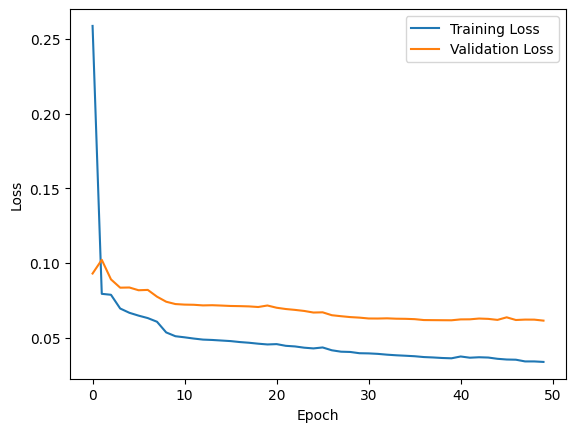

In [12]:
# loss plot
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

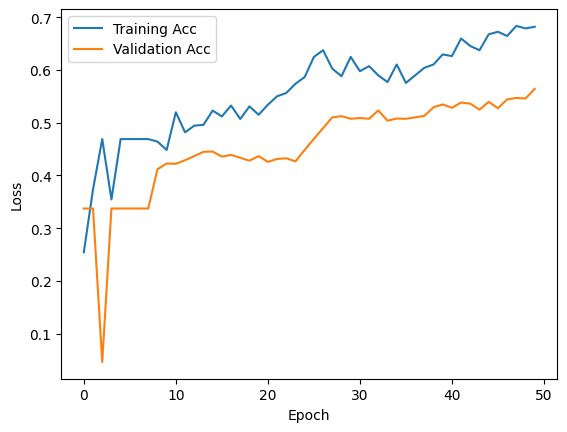

In [13]:
# acc plot
plt.plot(history.history["acc"], label="Training Acc")
plt.plot(history.history["val_acc"], label="Validation Acc")
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

In [14]:
new_X_train_domain = model.predict(resampled_X_train)
print(new_X_train_domain.shape)

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
(2203, 17)


GridSearch

In [15]:
logreg = LogisticRegression(random_state=42)
# Define hyperparameters to tune using GridSearchCV
param_grid = {'C': [1e-07, 1e-06, 1e-05, 0.0001, 0.001, 0.01], "penalty":["l2"]}
# Initialize GridSearchCV with the classifier and hyperparameters
grid_search = GridSearchCV(logreg, param_grid, cv=5,scoring='roc_auc')
# Fit the classifier using the compressed test data
grid_search.fit(new_X_train_domain, resampled_y_train)
# Get the best estimator from GridSearchCV
best_logreg = grid_search.best_estimator_

Prediction

In [16]:
y_pred = best_logreg.predict(X_test)
y_pred_prob = best_logreg.predict_proba(X_test)[::,1]
y_pred

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

Accuracy = 99.00%
Precision = 0.0
Recall = 0.0
f-1 score = 0.0

Classification Report:
               precision    recall  f1-score   support

           0       0.99      1.00      0.99       396
           1       0.00      0.00      0.00         4

    accuracy                           0.99       400
   macro avg       0.49      0.50      0.50       400
weighted avg       0.98      0.99      0.99       400



c:\Users\hydro\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\hydro\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\hydro\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start,

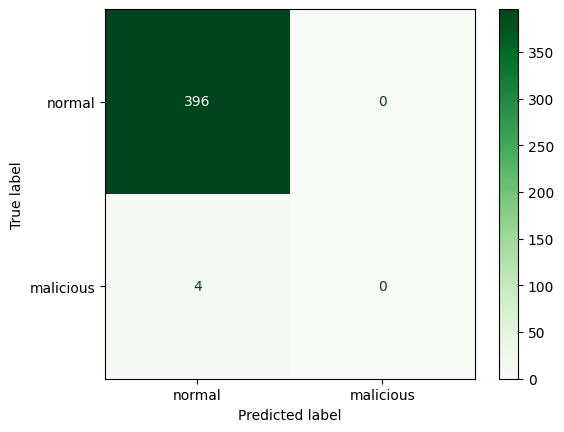

In [17]:
accuracy = accuracy_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels = ['normal', 'malicious'])

print("Accuracy = {:.2f}%".format(accuracy_score(y_test, y_pred)*100))
print("Precision = {}".format(precision_score(y_test, y_pred)))
print("Recall = {}".format(recall_score(y_test, y_pred)))
print("f-1 score = {}".format(f1_score(y_test, y_pred)))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
disp.plot(cmap=plt.cm.Greens)
plt.show()

AUC score: 0.5


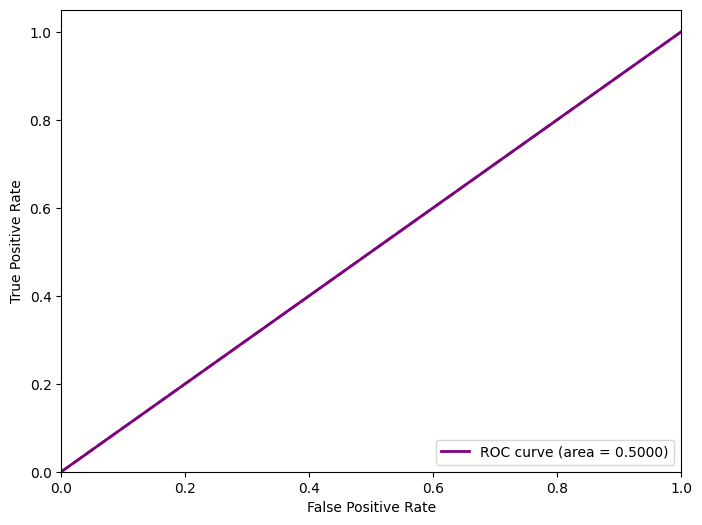

In [18]:
# ROC - AUC
def plot_roc_curve(true_y, y_prob):
    """
    plots the roc curve based of the probabilities
    """
    plt.figure(figsize=(8, 6))
    #y_prob = best_dt.predict_proba(X_test_scaled)[::,1]
    dt_fpr, dt_tpr, thresholds = roc_curve(true_y, y_prob)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.plot([0, 1], [0, 1], color='grey', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    roc_auc = auc(dt_fpr, dt_tpr)
    plt.plot(dt_fpr, dt_tpr, color='purple', lw=2, label='ROC curve (area = %0.4f)' % roc_auc)
    plt.legend(loc="lower right")

    # plt.legend()

plot_roc_curve(y_test, y_pred)
print(f'AUC score: {roc_auc_score(y_test, y_pred)}')

In [19]:
# Get the best estimator from GridSearchCV
best_logreg = grid_search.best_estimator_

# Use the best classifier to predict on test data
y_pred = best_logreg.predict(compressed_X_test)


NameError: name 'compressed_X_test' is not defined

### feature importance

In [20]:
# Feature Selection
rfe = RFECV(estimator = logreg, scoring = 'precision') #minimises false positives
X_train_rfe = rfe.fit_transform(X_train, y_train)
X_test_rfe = rfe.transform(X_test)

print('Chosen best features by rfe:', X_train.columns[rfe.support_].tolist())
print('Ranking of Feature Importance:', rfe.ranking_)

c:\Users\hydro\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\hydro\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\hydro\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: 

Chosen best features by rfe: ['N']
Ranking of Feature Importance: [ 2  3  4 16  1 11 10 17 13  7  8 14  9 12  6  5 15]


c:\Users\hydro\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but RFECV was fitted with feature names
  warnings.warn(


In [21]:
best_logreg = grid_search.best_estimator_

# Use encoder part of the autoencoder for feature selection

encoded_features_train = model.encoder.predict(X_train)
encoded_features_test = model.encoder.predict(X_test)

# Display the shape of extracted features
print("Encoded Features Shape (Train):", encoded_features_train.shape)
print("Encoded Features Shape (Test):", encoded_features_test.shape)

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 821us/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
Encoded Features Shape (Train): (1600, 8)
Encoded Features Shape (Test): (400, 8)


In [22]:
# Fit a logistic regression model using the selected features
model = LogisticRegression()
model.fit(encoded_features_train, y_train)

# Make predictions on the test set
y_pred = model.predict(encoded_features_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy with Selected Features:", accuracy)

Accuracy with Selected Features: 0.99


<Axes: >

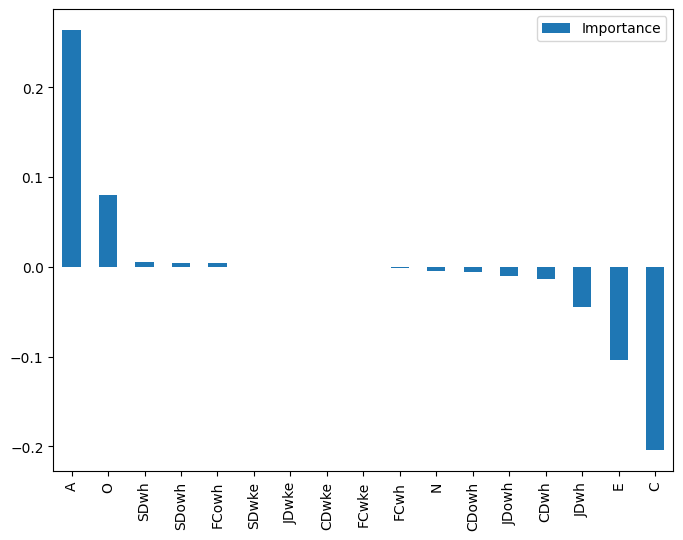

In [23]:
# feature importance
feat_importances = pd.DataFrame(best_logreg.coef_[0], index=X_train.columns, columns=["Importance"])
feat_importances.sort_values(by='Importance', ascending=False, inplace=True)
feat_importances.plot(kind='bar', figsize=(8,6))

### Risk scores

In [24]:
def get_risk_score(logreg, X):
    def min_max_scaling(value, new_min, new_max):
        old_min = min(value)
        old_max = max(value)
        scaled_value = ((value - old_min) / (old_max - old_min)) * (new_max - new_min) + new_min
        return scaled_value
    
    # distance from decision boundary where negative = non anomaly and positive = anomaly
    distances = logreg.decision_function(X)
    risk_scores = min_max_scaling(distances, 0,1)
    
    return risk_scores

In [25]:
train_risk = get_risk_score(best_logreg, resampled_X_train)
test_risk = get_risk_score(best_logreg, X_test)

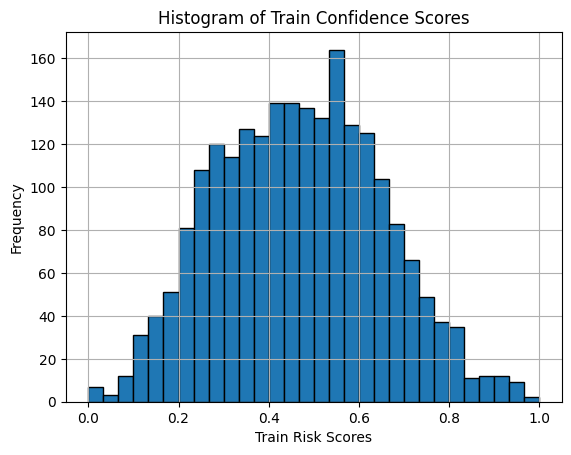

In [26]:
# Plot histogram for train risk score
plt.hist(train_risk, bins=30, edgecolor='black')  # Adjust bins as needed
plt.xlabel('Train Risk Scores')
plt.ylabel('Frequency')
plt.title('Histogram of Train Confidence Scores')
plt.grid(True)
plt.show()

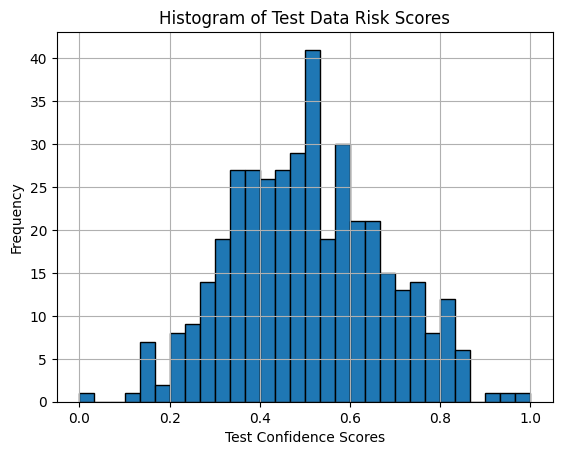

In [27]:
# Plot histogram for test risk score
plt.hist(test_risk, bins=30, edgecolor='black')  # Adjust bins as needed
plt.xlabel('Test Confidence Scores')
plt.ylabel('Frequency')
plt.title('Histogram of Test Data Risk Scores')
plt.grid(True)
plt.show()

In [28]:
print("Example Train Risk Scores:")
print(train_risk[:10])  
print("\nExample Test Risk Scores:")
print(test_risk[:10])

Example Train Risk Scores:
[0.59273611 0.6705506  0.20486488 0.56510331 0.53229954 0.44288562
 0.40503139 0.5448579  0.48797835 0.26436159]

Example Test Risk Scores:
[0.41245415 0.26880677 0.40026431 0.46581015 0.54397116 0.82818377
 0.74225099 0.25196688 0.53209436 0.36041657]


### exporting fn/tn/fp/tp to csv

In [29]:
# Convert the 'user' column from each Dask DataFrame to a Pandas Series
user_tn = filtered_tn['user'].compute()
user_tp = filtered_tp['user'].compute()
user_fn = filtered_fn['user'].compute()
user_fp = filtered_fp['user'].compute()

# Create a Pandas DataFrame with the 'user' columns from each Dask DataFrame
combined_df = pd.DataFrame({
    'user_tn': user_tn,
    'user_tp': user_tp,
    'user_fn': user_fn,
    'user_fp': user_fp
})

# Export the combined DataFrame to a CSV file
combined_df.to_csv('combined_users.csv', index=False)


NameError: name 'filtered_tn' is not defined